### load libraries

In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

### import the data we gathered from MSD Taste Profiles and Spotify Web API

In [2]:
msd_spot_df = pd.read_csv('taste_profiles_spotify.csv', index_col=0, header=0, dtype={'userID': str, 'songID': str, 
    'playcount': int, 'trackID': str, 'artist': str, 'title': str, 'trackID_spot': str, 'artistID_spot': str,
    'artistGenres': str, 'artistPop': int, 'trackPop': int, 'trackAcoustic': float, 'trackDanceable': float,
    'trackDurMS': int, 'trackEnergy': float, 'trackInstrum': float, 'trackKey': int, 'trackLoud': float, 'trackMode': int,
    'trackSpeech': float, 'trackTempo': float, 'trackVal': float, 'albumYear': int})

msd_spot_df

,userID,songID,playcount,trackID,artist,title,trackID_spot,artistID_spot,artistGenres,artistPop,...,trackDurMS,trackEnergy,trackInstrum,trackKey,trackLoud,trackMode,trackSpeech,trackTempo,trackVal,albumYear
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1,TRIRLYL128F42539D1,Billy Preston,Nothing from Nothing,72PoJMDfdaw9gGECgA9kTZ,0IecGJbdBeYSOVtSPRehh5,"classic soul, funk, psychedelic soul, quiet st...",53,...,156200,0.830,0.011200,9,-3.995,0,0.0283,102.800,0.909,1974
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2,TRMHBXZ128F4238406,Paco De Lucia,Entre Dos Aguas,5hVqZ5hnvQGT4LOpUVuJUa,3h8OjAdgYXVRoMZ8jFd6Uw,"flamenco, flamenco guitar, rumba",55,...,360426,0.654,0.874000,4,-12.673,0,0.0349,102.814,0.924,1997
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1,TRYQMNI128F147C1C7,Josh Rouse,Under Cold Blue Stars,4HWqzvmeiaddzCDkSQcNxf,38euc5ce2q2MMzaoJcPstz,alternative country,44,...,196333,0.692,0.000008,1,-6.880,1,0.0266,100.614,0.523,2002
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBSUJE12A6D4F8CF5,2,TRPLAXZ128F4292406,Jorge Drexler,12 segundos de oscuridad,5GCB9mqJzKN4kDKvmqQ03X,4ssUf5gLb1GBLxi1BhPrVt,"cantautor, latin afrobeat, latin alternative, ...",68,...,164946,0.423,0.001160,7,-9.239,1,0.0302,78.005,0.507,2006
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBXHDL12A81C204C0,1,TRHNCIR128F42334A5,Kanye West,Stronger,0j2T0R9dR9qdJYsB7ciXhf,5K4W6rqBFWDnAN6FQUkS6x,"chicago rap, rap",92,...,311866,0.717,0.000000,10,-7.858,0,0.1530,103.992,0.490,2007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10633750,cf8289419383259189afe6bb50c5115fd84f1064,SOHKQSO12A8AE47C9C,10,TRPLVWY12903CC08D3,Everything But The Girl,Time After Time,5RxNm1sQygVKpY9hEOvid5,13ccXrK7AmXb4TddMkE7jy,"electronica, new wave pop, pop rock, sophisti-...",60,...,269360,0.203,0.000006,0,-13.612,1,0.0323,120.370,0.326,1992
10633751,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOABJBU12A8C13F63F,2,TRUDZCV128F42811F6,Cage The Elephant,Back Against The Wall,0vz64VTiPPBpcmla0QvAI9,26T3LtbuGT1Fu9m0eRq5X3,"modern rock, punk blues, rock",75,...,228320,0.743,0.000000,1,-6.163,1,0.0305,110.334,0.534,2009
10633752,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOEISDE12A8AE4632E,1,TRKIBVN128F42283F4,King Kobra,Only The Strong Will Survive,5sUy4vaMwn4YCMPlr0RW0g,60DhbkIV5C2aLGgtpfUw2C,"glam metal, hard rock, sleaze rock",36,...,240372,0.853,0.000000,4,-4.691,1,0.0328,91.632,0.550,1986
10633753,b7815dbb206eb2831ce0fe040d0aa537e2e800f7,SOHHKGO12AC3DF57BF,1,TRODVNR12903CE6C50,Close Your Eyes,17:20,0IUhBvxsm2pLz6rzEM3YUn,4EJdKdDfQ0XQ4YBhh12xZe,christian hardcore,34,...,136920,0.899,0.089900,11,-4.449,1,0.1680,186.031,0.775,2010


In both the Val-Aro-Dep and MUSIC models, those components were found by rating music from various genres accrording to descriptive sound-related (instrumental, loud, electric...) or psychological (intense, relaxing, sad...) attributes. We were able to get some similar types of attribute scores from the Spotify Web API, although these are not direct matches to what's in the literature. But let's try to select the attributes that are the closest matches and do some clustering based on that.

Let's look at the attributes: 

- trackAcoustic (sound related, could be the inverse analogue to the "electric" attribute in MUSIC paper)
- trackInstrum (sound related, instrumental is an attribute used in MUSIC paper)
- trackLoud (sound related, loud is an attribute used in MUSIC paper)
- trackTempo (sound related, fast is an attribute used in MUSIC paper)
- trackVal (psychological, sad is an attribute used in MUSIC and V-A-D paper)
- trackDanceable (psychological, danceable is an attribute used in V-A-D paper)

Note, we are excluding the energy metric for the time being. Spotify describes this as being related to many of the other acoustic features we already have on our list (we also saw this during the data exploration). So we will leave this one out for now due to the correlations.

In [77]:
msd_spot_clust_df = msd_spot_df[['trackAcoustic', 'trackInstrum', 'trackLoud', 'trackTempo', 'trackVal', 'trackDanceable']]
msd_spot_clust_df.head()

,trackAcoustic,trackInstrum,trackLoud,trackTempo,trackVal,trackDanceable
0,0.61300,0.011200,-3.995,102.800,0.909,0.808
1,0.92300,0.874000,-12.673,102.814,0.924,0.461
2,0.02360,0.000008,-6.880,100.614,0.523,0.613
3,0.65100,0.001160,-9.239,78.005,0.507,0.749
4,0.00564,0.000000,-7.858,103.992,0.490,0.617


### plot the ranges of the attributes we are going to use

These data have various ranges, some are scaled to [0, 1] but others have units (like BPM or dB). Lets standardize everything.

In [78]:
msd_spot_clust_df = StandardScaler().fit_transform(msd_spot_clust_df)
msd_spot_clust_df = pd.DataFrame(msd_spot_clust_df, columns=['trackAcoustic', 'trackInstrum', 'trackLoud', 'trackTempo', 'trackVal', 'trackDanceable'])
msd_spot_clust_df.head()

,trackAcoustic,trackInstrum,trackLoud,trackTempo,trackVal,trackDanceable
0,1.259146,-0.461198,1.046453,-0.672036,1.611714,1.512089
1,2.306686,2.580580,-1.070617,-0.671549,1.671528,-0.539553
2,-0.732530,-0.500657,0.342633,-0.748051,0.072495,0.359149
3,1.387554,-0.496594,-0.232864,-1.534250,0.008693,1.163251
4,-0.793220,-0.500684,0.104042,-0.630585,-0.059096,0.382799


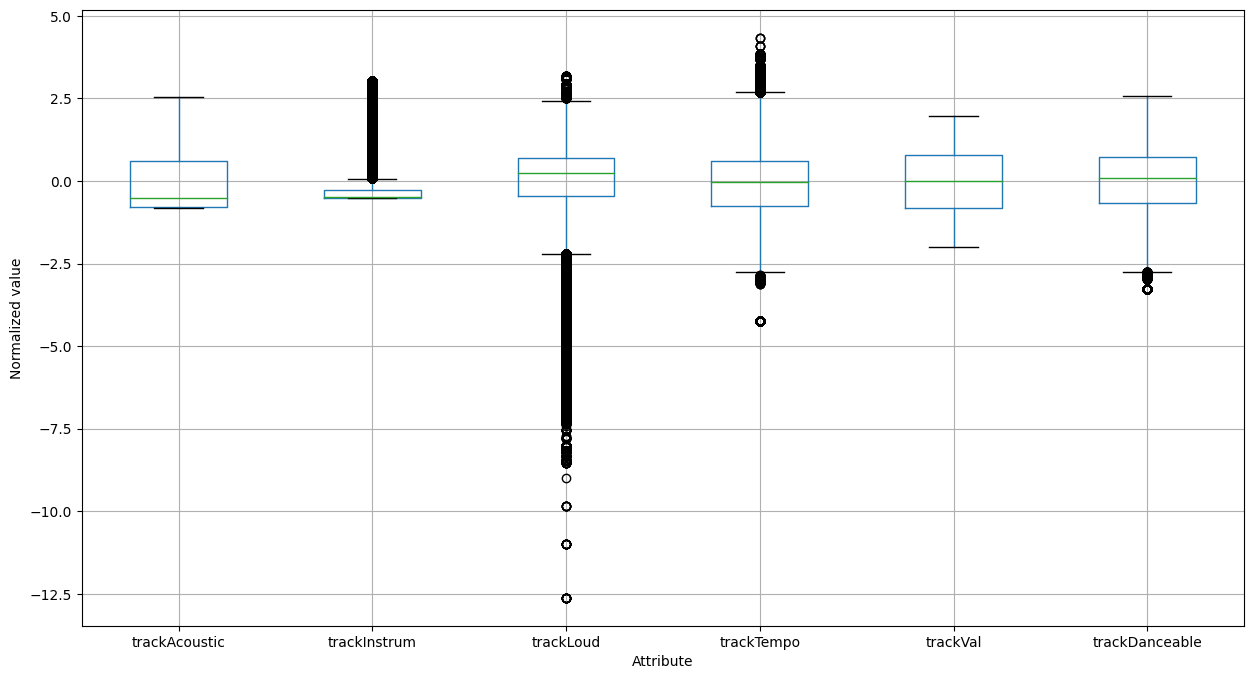

In [79]:
axs = msd_spot_clust_df[['trackAcoustic', 'trackInstrum', 'trackLoud', 'trackTempo', 'trackVal', 'trackDanceable']].boxplot(figsize=(15,8), return_type='axes')
axs.set_xlabel('Attribute')
axs.set_ylabel('Normalized value')

plt.show()

It looks like we have a lot of outliers in some of the attributes, which may cause us some issue with kmeans clustering.

Let's see how many outliers we have per attribute

In [80]:
#calculate interquartile range
q1 = msd_spot_clust_df.quantile(0.25)
q3 = msd_spot_clust_df.quantile(0.75)

for i,col in enumerate(msd_spot_clust_df.columns):
    print(i, col, ":", (~msd_spot_clust_df[col].between(q1[i]-1.5*(q3[i]-q1[i]), q3[i]+1.5*(q3[i]-q1[i]))).values.sum(), "outliers")

0 trackAcoustic : 0 outliers
1 trackInstrum : 2200270 outliers
2 trackLoud : 352721 outliers
3 trackTempo : 66581 outliers
4 trackVal : 0 outliers
5 trackDanceable : 14241 outliers


In [38]:
len(msd_spot_clust_df)

10633755

Let's just remove all the outlier points for simplicity, since we will still have a lot of data remaining. Except for the Instrumentalness outliers because there's a lot of those. Let's just leave those in for now and see what the data looks like

In [81]:
msd_spot_clust_df = msd_spot_clust_df.loc[(msd_spot_clust_df['trackLoud'].between(q1[2]-1.5*(q3[2]-q1[2]), q3[2]+1.5*(q3[2]-q1[2]))) & (msd_spot_clust_df['trackTempo'].between(q1[3]-1.5*(q3[3]-q1[3]), q3[3]+1.5*(q3[3]-q1[3]))) & (msd_spot_clust_df['trackDanceable'].between(q1[5]-1.5*(q3[5]-q1[5]), q3[5]+1.5*(q3[5]-q1[5]))),:]
msd_spot_clust_df.reset_index(inplace=True)

In [82]:
msd_spot_clust_df.drop(columns=['index'], inplace=True)
msd_spot_clust_df

,trackAcoustic,trackInstrum,trackLoud,trackTempo,trackVal,trackDanceable
0,1.259146,-0.461198,1.046453,-0.672036,1.611714,1.512089
1,2.306686,2.580580,-1.070617,-0.671549,1.671528,-0.539553
2,-0.732530,-0.500657,0.342633,-0.748051,0.072495,0.359149
3,1.387554,-0.496594,-0.232864,-1.534250,0.008693,1.163251
4,-0.793220,-0.500684,0.104042,-0.630585,-0.059096,0.382799
...,...,...,...,...,...,...
10210589,2.225586,-0.500663,-1.299694,-0.061061,-0.713064,0.187686
10210590,-0.810105,-0.500684,0.517551,-0.410050,0.116359,0.270461
10210591,-0.153342,-0.500684,0.876658,-1.060389,0.180161,-0.545466
10210592,-0.812260,-0.183743,0.935696,2.222217,1.077374,-2.064981


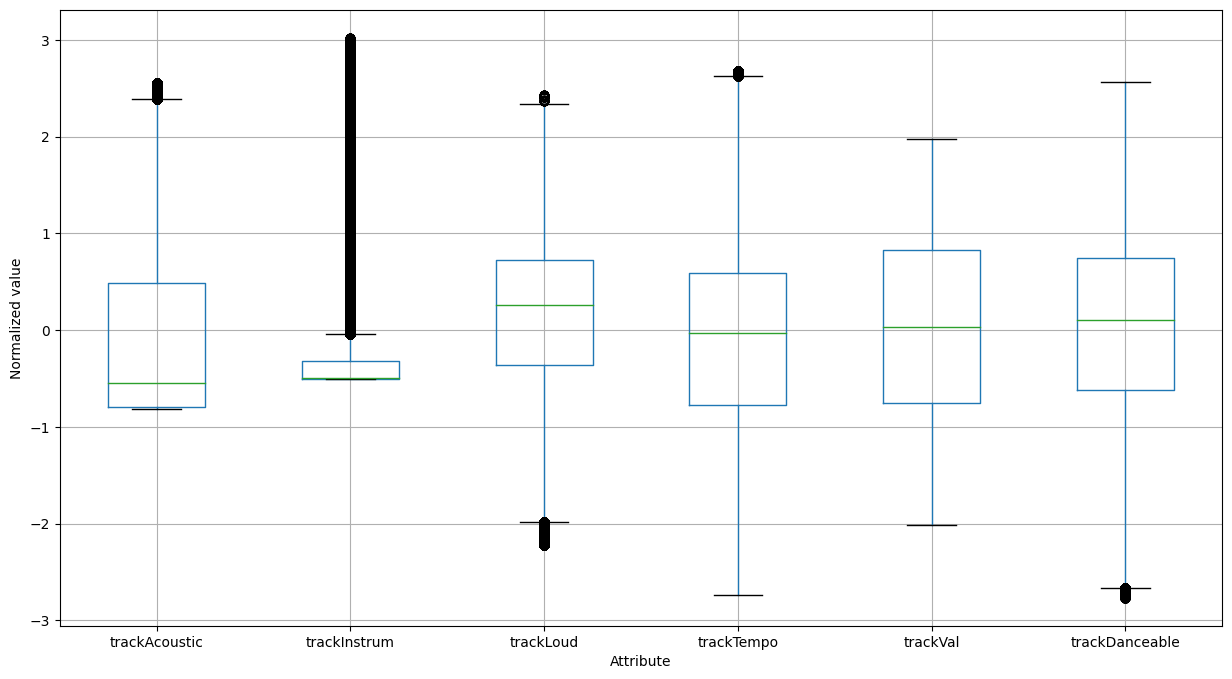

In [83]:
axs = msd_spot_clust_df[['trackAcoustic', 'trackInstrum', 'trackLoud', 'trackTempo', 'trackVal', 'trackDanceable']].boxplot(figsize=(15,8), return_type='axes')
axs.set_xlabel('Attribute')
axs.set_ylabel('Normalized value')

plt.show()

This looks better.... but Instrumentalness still appears to have a huge skew in the data, which may be a problem later. Let's visualize this:

<AxesSubplot: >

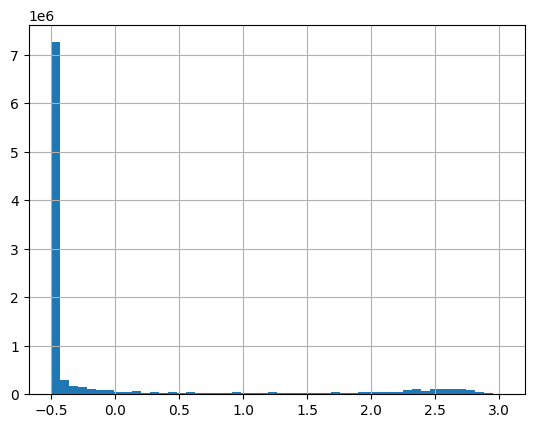

In [96]:
msd_spot_clust_df['trackInstrum'].hist(bins=50)

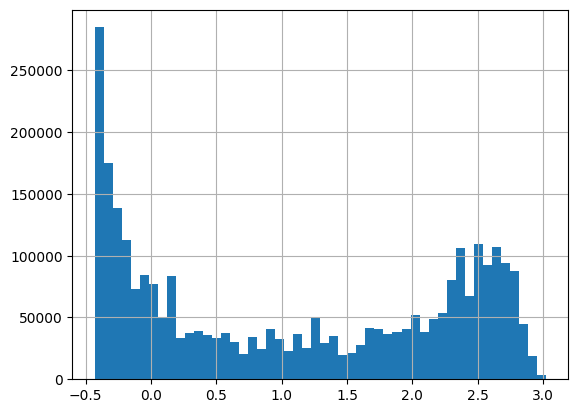

In [101]:
msd_spot_clust_df[msd_spot_clust_df['trackInstrum'] > -0.43]['trackInstrum'].hist(bins=50)

Let's resample this data so that Instrumentation is not so skewed, because this is a substantial skew.

Also 10 million data points is too many for my computer to attempt to handle (especially since SKLearn does not provide GPU support) so having fewer datapoints would be helpful.

In [107]:
counts, bins = np.histogram(msd_spot_clust_df['trackInstrum'], bins=50)
print("bins:", bins)
print("counts", counts)

bins: [-0.50068354 -0.43024458 -0.35980563 -0.28936668 -0.21892772 -0.14848877
 -0.07804981 -0.00761086  0.06282809  0.13326705  0.203706    0.27414495
  0.34458391  0.41502286  0.48546181  0.55590077  0.62633972  0.69677867
  0.76721763  0.83765658  0.90809553  0.97853449  1.04897344  1.1194124
  1.18985135  1.2602903   1.33072926  1.40116821  1.47160716  1.54204612
  1.61248507  1.68292402  1.75336298  1.82380193  1.89424088  1.96467984
  2.03511879  2.10555774  2.1759967   2.24643565  2.3168746   2.38731356
  2.45775251  2.52819147  2.59863042  2.66906937  2.73950833  2.80994728
  2.88038623  2.95082519  3.02126414]
counts [7257104  290712  177147  143276  108543   96960   80123   56353   56945
   75339   34634   39484   36231   44199   27931   40837   26051   26350
   29072   34727   38810   24964   32370   32813   43708   36325   26863
   34307   20257   27625   32653   46784   33339   31229   54515   48681
   38454   50438   51001   80760  108546   63953  107810  100979  102233
 

In [108]:
print(min(counts))

3800


Let's just make this a uniform distribution. So randomly sample 3800 points from each bin-- that will still give us 190k datapoints for clustering, which should be sufficient to find the centroids

### to do: get the labels for our data (this will be genre for each song)

### How many clusters are in our data?

### Elbow method:

(use this as an initial check/guide for optimal k)

computing k= 1
computing k= 2
computing k= 3
computing k= 4
computing k= 5
computing k= 6
computing k= 7
computing k= 8
computing k= 9
computing k= 10


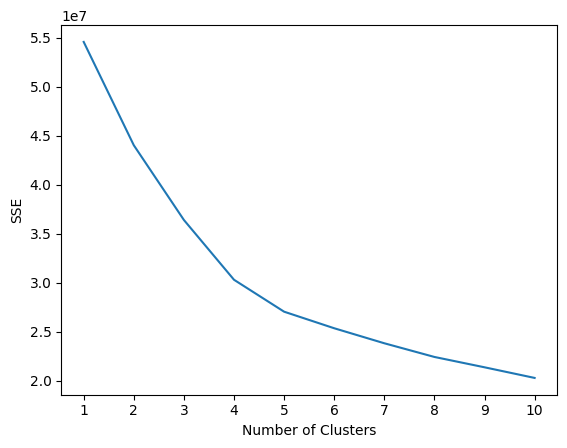

In [88]:
#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 42,
}

#create list to hold SSE values for each k
sse = []
for k in range(1, 11):
    print("computing k=",k)
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(msd_spot_clust_df)
    sse.append(kmeans.inertia_)
    
#visualize results
plt.plot(range(1, 11), sse)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

### Silhouette score:

In [ ]:
#initialize kmeans parameters
kmeans_kwargs = {
"init": "random",
"n_init": 10,
"random_state": 42,
}

sil_score = []
for k in range(2, 11):
    print("computing k=",k)
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    cluster_labels = kmeans.fit_predict(msd_spot_clust_df)
    sil_score.append(silhouette_score(msd_spot_clust_df, cluster_labels))
    
#visualize results
plt.plot(range(2, 11), sil_score)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Avg Silhouette Score")
plt.show()